# **1. Perkenalan Dataset**


1. **Sumber Dataset**:  
   Data yang saya pakai adalah data yang diambil dari **kaggle** degan judul **"Fraud Detection Dataset"**. data ini terdiri dari 6 juta row dengan 11 kolom. dengan link berikut : https://www.kaggle.com/datasets/amanalisiddiqui/fraud-detection-dataset/data


# **2. Import Library**

In [2]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt 
import seaborn as sns 
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score # metricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import plotly.express as px


# **3. Memuat Dataset**

In [3]:
import kagglehub

path = kagglehub.dataset_download("amanalisiddiqui/fraud-detection-dataset")

print("Path to dataset files:", path)

df = pd.read_csv(f"{path}/AIML Dataset.csv")

/Users/axzolotle/miniconda3/envs/ml-train/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 178M/178M [03:24<00:00, 911kB/s]  

Extracting files...


Path to dataset files: /Users/axzolotle/.cache/kagglehub/datasets/amanalisiddiqui/fraud-detection-dataset/versions/1


In [4]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


# **4. Exploratory Data Analysis (EDA)**

pada eksplorasi data ini kami menemukan beberapa informasi tentang data fraud yang kami pakai ini

In [6]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [7]:
df_fraud = df[df['isFraud']==1]
summary = df_fraud.groupby('isFlaggedFraud').size().reset_index(name='count')
summary['isFlaggedFraud'] = summary['isFlaggedFraud'].map({
    0:'Not flagged',
    1:'Flagged'
})

In [8]:
source = summary

alt.Chart(source).mark_bar().encode(
    x='isFlaggedFraud:N',
    y='count:Q',
    color='isFlaggedFraud:N',
    tooltip=["isFlaggedFraud", "count"]
).properties(
   title="perbandingan antara data fraud yang sudah terdeteksi(flaggeds) dan tidak terdeteksi(not flagged)",
    width=700,
    height=500
)

alt.Chart(...)

/var/folders/9k/h0lbnpxx7rx3hzlgqg7wvwkr0000gn/T/ipykernel_58347/2646860259.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()


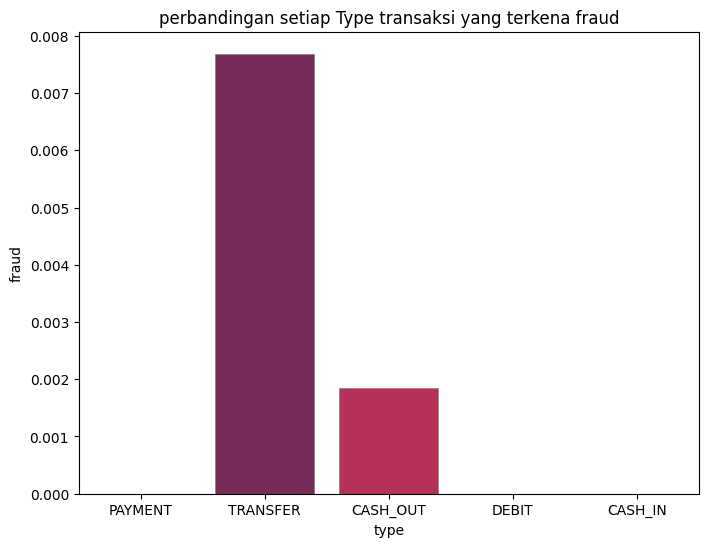

In [9]:
plt.figure(figsize=(8,6))
sns.barplot(
    data=df,
    x='type',
    y='isFraud',
    hue='type',
    errorbar=None,
    palette="rocket",
    linewidth=.5,
    edgecolor=".5"
)
plt.xlabel("type")  
plt.ylabel("fraud")
plt.title("perbandingan setiap Type transaksi yang terkena fraud")
plt.legend().remove() 
plt.show()

In [10]:
transfer_fraud = df_fraud[df_fraud["type"]== "TRANSFER"]

top_accounts = (
    transfer_fraud.groupby("nameDest")["amount"]
    .sum()
    .nlargest(10)
    .index
)

transfer_fraud = transfer_fraud[transfer_fraud["nameDest"].isin(top_accounts)]

transfer_fraud = transfer_fraud.sort_values(by=["nameDest","step"])

accounts = transfer_fraud["nameDest"].unique()
charts = []

for account in accounts:
    account_data = transfer_fraud[transfer_fraud['nameDest'] == account]

    chart = alt.Chart(account_data).mark_line(point=True).encode(
        x=alt.X("step:O", title="Time or step"),
        y=alt.Y("amount:Q", title=f"Amount sent to account {account}"),
        tooltip=[
            alt.Tooltip("amount:Q"),
            alt.Tooltip("nameDest:N")
        ]
    ).properties(
        title=f"fraudulent account {account}, transactions recieved",
        width=400,
        height=300
    )
    charts.append(chart)
n_cols = 5
rows = [alt.hconcat(*charts[i:i + n_cols]) for i in range(0,len(charts),n_cols)]
mosaic = alt.vconcat(*rows)

mosaic

alt.VConcatChart(...)

In [11]:
df_trans_grouped = df[df["type"] == "TRANSFER"].copy()

df_trans_grouped["isFraud"] = df_trans_grouped["isFraud"].map({
    0: "Not Fraud",
    1: "Fraud"
})

df_trans_grouped["step_group"] = (df_trans_grouped["step"] // 24) * 24

df_step_block = (
    df_trans_grouped
    .groupby(["step_group", "isFraud"])
    .size()
    .reset_index(name="count") 
)

alt.Chart(df_step_block).mark_bar(opacity=0.7).encode(
    x=alt.X("step_group:O", title="Time step (grouped every 24 steps)"),
    y=alt.Y("count:Q", title="Number of Transfers"),
    color=alt.Color("isFraud:N", title="Fraud Status"),
    tooltip=["step_group", "count", "isFraud"]
).properties(
    width=700,
    height=400,
    title="data transaksi per 24 step - Fraud vs Non-Fraud"
)

alt.Chart(...)

# **5. Data Preprocessing**

Pada tahap ini, data preprocessing yang saya lakukan hanyalah drop duplicate dan check missing value. karena data yang saya pakai cukup bagus dan tidak memerlukan banyak tahap cleaning

In [12]:
df_for_train = pd.get_dummies(df,columns=['type'],drop_first=True)

In [16]:
duplicated = df_for_train.duplicated().sum() 
duplicated
df_for_train.drop_duplicates()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,False,False,True,False
1,1,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,False,False,True,False
2,1,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,False,False,False,True
3,1,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,True,False,False,False
4,1,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,True,False,False,False
6362616,743,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,False,False,False,True
6362617,743,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,True,False,False,False
6362618,743,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,False,False,False,True


In [17]:
df_nulls = df_for_train.isnull().sum()

df_nulls

step              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
type_CASH_OUT     0
type_DEBIT        0
type_PAYMENT      0
type_TRANSFER     0
dtype: int64

In [26]:
df_for_train.drop(columns=['nameOrig','nameDest'],inplace=True)

In [27]:
x = 230000
df_small = df_for_train.sample(n=x, random_state=42)
data_clean = df_small.to_csv("data_clean.csv", index=False)

In [28]:
df_small.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
3737323,278,330218.42,20866.00,351084.42,452419.57,122201.15,0,0,False,False,False,False
264914,15,11647.08,30370.00,18722.92,0.00,0.00,0,0,False,False,True,False
85647,10,152264.21,106589.00,258853.21,201303.01,49038.80,0,0,False,False,False,False
5899326,403,1551760.63,0.00,0.00,3198359.45,4750120.08,0,0,False,False,False,True
2544263,206,78172.30,2921331.58,2999503.88,415821.90,337649.60,0,0,False,False,False,False
